### 4.5. GBM

#### [4.4. 랜덤포레스트 예제] 결정 트리 실습-사용자 행동 인식 dataset

In [1]:
from google.colab import drive
drive.mount('/content/gdrive/')

path = "/content/gdrive/MyDrive/Euron/"

Mounted at /content/gdrive/


In [2]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

feature_name_df = pd.read_csv(path+'human_activity/features.txt', sep='\s+',
                          header=None, names=['column_index', 'column_name'])

# 피처명 index 제거, 피처명만 list 객체로 생성
feature_name = feature_name_df.iloc[:,1].values.tolist()
print("전체에서 10개만 추출:", feature_name[:10])

전체에서 10개만 추출: ['tBodyAcc-mean()-X', 'tBodyAcc-mean()-Y', 'tBodyAcc-mean()-Z', 'tBodyAcc-std()-X', 'tBodyAcc-std()-Y', 'tBodyAcc-std()-Z', 'tBodyAcc-mad()-X', 'tBodyAcc-mad()-Y', 'tBodyAcc-mad()-Z', 'tBodyAcc-max()-X']


In [3]:
# 중복된 피처명 알아보기
feature_dup_df=feature_name_df.groupby('column_name').count()
print(feature_dup_df[feature_dup_df['column_index']>1].count())
feature_dup_df[feature_dup_df['column_index']>1].head()

column_index    42
dtype: int64


,column_index
column_name,
"fBodyAcc-bandsEnergy()-1,16",3
"fBodyAcc-bandsEnergy()-1,24",3
"fBodyAcc-bandsEnergy()-1,8",3
"fBodyAcc-bandsEnergy()-17,24",3
"fBodyAcc-bandsEnergy()-17,32",3


In [4]:
# 42개의 피처명 중복

In [5]:
# 원본 피처명에 _1, _2 추가하기
def get_new_feature_name_df(old_feature_name_df):
  feature_dup_df=pd.DataFrame(data=old_feature_name_df.groupby('column_name').cumcount(), columns=['dup_cnt'])
  feature_dup_df=feature_dup_df.reset_index()
  new_feature_name_df=pd.merge(old_feature_name_df.reset_index(),feature_dup_df,how='outer')
  new_feature_name_df['column_name']=new_feature_name_df[['column_name', 'dup_cnt']].apply(lambda x:x[0]+'_'+str(x[1]) if x[1]>0 else x[0], axis=1)
  new_feature_name_df=new_feature_name_df.drop(['index'],axis=1)
  return new_feature_name_df

In [6]:
import pandas as pd

def get_human_dataset():

  # read_csv에서 공백 문자를 sep로 할당
  feature_name_df=pd.read_csv(path+'human_activity/features.txt',sep='\s+',
                          header=None, names=['column_index', 'column_name'])

  # 중복된 피처명 수정하는 get_new_feature_name_df( ) 이용, 신규 피처명 DataFrame 설정
  new_feature_name_df=get_new_feature_name_df(feature_name_df)

  # DataFrame에 피처명을 칼럼으로 부여하기 위해 list로 변환
  feature_name=new_feature_name_df.iloc[:,1].values.tolist()

  # 학습/테스트 피처 데이터를 DataFrame으로 로딩, 칼럼명은 feature_name 적용
  X_train=pd.read_csv(path+'human_activity/train/X_train.txt',sep='\s+',names=feature_name)
  X_test=pd.read_csv(path+'human_activity/test/X_test.txt',sep='\s+',names=feature_name)

  # 학습/테스트 레이블 데이터를 DataFrame으로 로딩, 칼럼명은 action으로 부여
  y_train=pd.read_csv(path+'human_activity/train/y_train.txt',sep='\s+',header=None,names=['action'])
  y_test=pd.read_csv(path+'human_activity/test/y_test.txt',sep='\s+',header=None,names=['action'])

  # 학습/테스트용 DataFrame 모두 반환
  return X_train,X_test,y_train,y_test

X_train,X_test,y_train,y_test=get_human_dataset()

<ipython-input-5-458d341262bc>:6: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  new_feature_name_df['column_name']=new_feature_name_df[['column_name', 'dup_cnt']].apply(lambda x:x[0]+'_'+str(x[1]) if x[1]>0 else x[0], axis=1)


#### GBM의 개요 및 실습

In [7]:
import pandas as pd

from sklearn.ensemble import VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

In [8]:
from sklearn.ensemble import GradientBoostingClassifier
import time
import warnings
warnings.filterwarnings('ignore')

In [13]:
X_train, X_test, y_train, y_test = get_human_dataset()

# GBM 수행시간 측정을 위함
start_time=time.time()  # 시작 시간 설정

gb_clf=GradientBoostingClassifier(random_state=0)
gb_clf.fit(X_train, y_train)
gb_pred=gb_clf.predict(X_test)
gb_accuracy=accuracy_score(y_test, gb_pred)

print('GBM 정확도: {0:.4f}'.format(gb_accuracy))
print('GBM 수행 시간: {0:.4f}'.format(time.time()-start_time))

GBM 정확도: 0.9386
GBM 수행 시간: 1213.1036


In [10]:
# 랜덤 포레스트보다 나은 예측 성능
# 그러나! 수행 시간이 오래 걸림 (순차적인 예측 오류 보정 => 병렬 처리로 수행하지 않음)

#### GBM 하이퍼 파라미터 및 튜닝

In [14]:
from sklearn.model_selection import GridSearchCV

params={
    'n_estimators':[100,500],
    'learning_rate':[0.05,0.1]
}
grid_cv=GridSearchCV(gb_clf, param_grid=params, cv=2, verbose=1)  # cv: 학습/검증 데이터 분할 수 (2개의 세트)
grid_cv.fit(X_train, y_train)
print('최적 하이퍼 파라미터:\n', grid_cv.best_params_)
print('최고 예측 정확도: {0:.4f}'.format(grid_cv.best_score_))

Fitting 2 folds for each of 4 candidates, totalling 8 fits


KeyboardInterrupt: 

In [16]:
# GridSearchCV를 이용하여 최적 학습 estimator로 예측 수행
gb_pred=grid_cv.best_estimator_.predict(X_test)
gb_accuracy=accuracy_score(y_test, gb_pred)
print('GBM 정확도: {0:.4f}'.format(gb_accuracy))

AttributeError: 'GridSearchCV' object has no attribute 'best_estimator_'

### 4.6. XGBoost

In [17]:
import xgboost as xgb
from xgboost import XGBClassifier

#### 파이썬 래퍼 XGBoost 하이퍼 파라미터

In [18]:
import xgboost
print(xgboost.__version__)

2.1.1


#### 파이썬 래퍼 XGBoost 적용-위스콘신 유방암 예측

In [19]:
import xgboost
from xgboost import plot_importance
import pandas as pd
import numpy as np
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings('ignore')

dataset=load_breast_cancer()
X_features=dataset.data
y_label=dataset.target

cancer_df=pd.DataFrame(data=X_features, columns=dataset.feature_names)
cancer_df['target']=y_label
cancer_df.head(3)

,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,...,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension,target
0,17.99,10.38,122.8,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,...,17.33,184.6,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890,0
1,20.57,17.77,132.9,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,...,23.41,158.8,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902,0
2,19.69,21.25,130.0,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,...,25.53,152.5,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758,0


In [20]:
print(dataset.target_names)
print(cancer_df['target'].value_counts())  # 0(maligant, 악성), 1(benign, 양성)

['malignant' 'benign']
target
1    357
0    212
Name: count, dtype: int64


In [21]:
# 전체 데이터 중 80%는 학습용 데이터, 20%는 테스트용 데이터 추출
X_train, X_test, y_train, y_test = train_test_split(X_features, y_label, test_size=0.2, random_state=156)

print(X_train.shape, X_test.shape)

(455, 30) (114, 30)


In [22]:
# numpy 형태의 학습/테스트 데이터 세트를 DMatrix로 변환
# data: 피처 데이터 세트, label: (분류) 레이블 데이터 세트, (회귀) 숫자형 종속값 데이터 세트
dtrain=xgb.DMatrix(data=X_train, label=y_train)
dtest=xgb.DMatrix(data=X_test, label=y_test)

* 하이퍼 파라미터 설정

In [23]:
params={
    'max_depth':3,
    'eta':0.1,
    'objective':'binary:logistic',
    'eval_metric':'logloss',
    'early_stoppings':100
}
num_rounds=400

* 학습

In [24]:
# train dataset: 'train', evaluation(test) dataset: 'eval'
wlist=[(dtrain, 'train'),(dtest, 'eval')]

# 하이퍼 파라미터, early stopping 파라미터를 train()함수의 파라미터로 전달
xgb_model=xgb.train(params=params, dtrain=dtrain, num_boost_round=num_rounds, \
                    early_stopping_rounds=100, evals=wlist)

[0]	train-logloss:0.58431	eval-logloss:0.56554
[1]	train-logloss:0.51885	eval-logloss:0.50669
[2]	train-logloss:0.46457	eval-logloss:0.45868
[3]	train-logloss:0.41713	eval-logloss:0.41822
[4]	train-logloss:0.37585	eval-logloss:0.38103
[5]	train-logloss:0.34075	eval-logloss:0.35137
[6]	train-logloss:0.31028	eval-logloss:0.32588
[7]	train-logloss:0.28283	eval-logloss:0.30127
[8]	train-logloss:0.25925	eval-logloss:0.28197
[9]	train-logloss:0.23822	eval-logloss:0.26265
[10]	train-logloss:0.21951	eval-logloss:0.24821
[11]	train-logloss:0.20251	eval-logloss:0.23231
[12]	train-logloss:0.18759	eval-logloss:0.22079
[13]	train-logloss:0.17386	eval-logloss:0.20795
[14]	train-logloss:0.16199	eval-logloss:0.19764
[15]	train-logloss:0.15109	eval-logloss:0.18950
[16]	train-logloss:0.14056	eval-logloss:0.18052
[17]	train-logloss:0.13137	eval-logloss:0.17246
[18]	train-logloss:0.12329	eval-logloss:0.16512
[19]	train-logloss:0.11565	eval-logloss:0.15828
[20]	train-logloss:0.10860	eval-logloss:0.15436
[2

* 예측

In [25]:
# cf. 사이킷런 predict(): 예측 결과 값 반환

pred_probs=xgb_model.predict(dtest)
print('predict() 수행 결괏값을 10개만 표시, 예측 확률값으로 표시됨')
print(np.round(pred_probs[:10],3))

# 예측확률이 0.5보다 크면 1, 그렇지 않으면 0으로 예측값 결정 -> list 객체 preds에 저장
preds=[1 if x>0.5 else 0 for x in pred_probs]
print('예측값 10개만 표시:', preds[:10])

predict() 수행 결괏값을 10개만 표시, 예측 확률값으로 표시됨
[0.904 0.004 0.908 0.267 0.992 1.    1.    0.999 0.994 0.   ]
예측값 10개만 표시: [1, 0, 1, 0, 1, 1, 1, 1, 1, 0]


* 예측 성능 평가

In [26]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix, f1_score, roc_auc_score

def get_clf_eval(y_test, pred=None, pred_proba=None):
  confusion = confusion_matrix(y_test, pred)
  accuracy = accuracy_score(y_test, pred)
  precision = precision_score(y_test, pred)
  recall = recall_score(y_test, pred)
  f1=f1_score(y_test,pred)
  roc_auc=roc_auc_score(y_test, pred_proba)
  print('오차 행렬')
  print(confusion)
  print('정확도: {0: .4f}, 정밀도: {1: .4f}, 재현율: {2:.4f}'.format(accuracy, precision, recall))

In [27]:
get_clf_eval(y_test, preds, pred_probs)

오차 행렬
[[34  3]
 [ 1 76]]
정확도:  0.9649, 정밀도:  0.9620, 재현율: 0.9870


* 시각화

<Axes: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

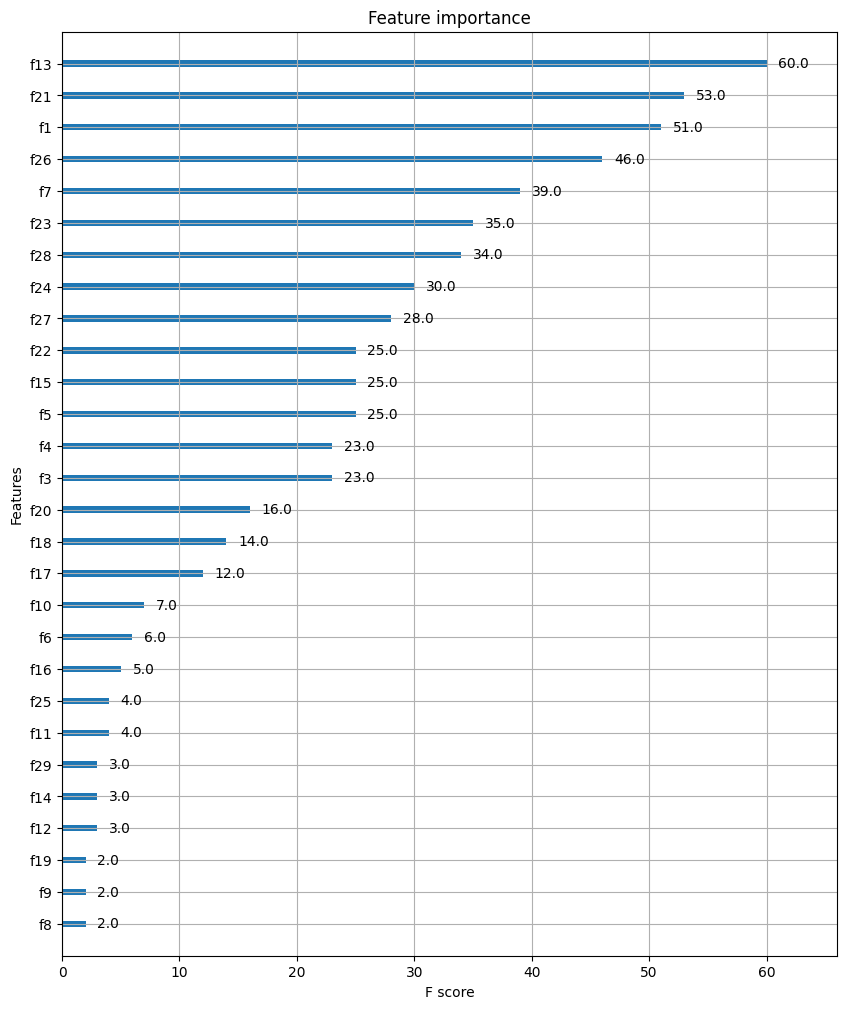

In [28]:
from xgboost import plot_importance
import matplotlib.pyplot as plt
%matplotlib inline

fig, ax = plt.subplots(figsize=(10,12))
plot_importance(xgb_model, ax=ax)

#### 사이킷런 래퍼 XGBoost 개요 및 적용

In [29]:
# 사이킷런 래퍼 XGBoostClassifier import
from xgboost import XGBClassifier

xgb_wrapper=XGBClassifier(n_estimators=400, learning_rate=0.1, max_depth=3)
xgb_wrapper.fit(X_train, y_train)
w_preds=xgb_wrapper.predict(X_test)
w_pred_proba=xgb_wrapper.predict_proba(X_test)[:,1]

In [30]:
get_clf_eval(y_test, w_preds, w_pred_proba)

오차 행렬
[[35  2]
 [ 1 76]]
정확도:  0.9737, 정밀도:  0.9744, 재현율: 0.9870


In [31]:
from xgboost import XGBClassifier

xgb_wrapper=XGBClassifier(n_estimators=400, learning_rate=0.1, max_depth=3, early_stopping_rounds=100, eval_metric="logloss", verbose=True)
evals=[(X_test, y_test)]
xgb_wrapper.fit(X_train, y_train, eval_set=evals)
ws100_preds=xgb_wrapper.predict(X_test)
ws100_pred_proba=xgb_wrapper.predict_proba(X_test)[:,1]

[0]	validation_0-logloss:0.56554
[1]	validation_0-logloss:0.50669
[2]	validation_0-logloss:0.45868
[3]	validation_0-logloss:0.41822
[4]	validation_0-logloss:0.38103
[5]	validation_0-logloss:0.35137
[6]	validation_0-logloss:0.32588
[7]	validation_0-logloss:0.30127
[8]	validation_0-logloss:0.28197
[9]	validation_0-logloss:0.26265
[10]	validation_0-logloss:0.24821
[11]	validation_0-logloss:0.23231
[12]	validation_0-logloss:0.22079
[13]	validation_0-logloss:0.20795
[14]	validation_0-logloss:0.19764
[15]	validation_0-logloss:0.18950
[16]	validation_0-logloss:0.18052
[17]	validation_0-logloss:0.17246
[18]	validation_0-logloss:0.16512
[19]	validation_0-logloss:0.15828
[20]	validation_0-logloss:0.15436
[21]	validation_0-logloss:0.14633
[22]	validation_0-logloss:0.13936
[23]	validation_0-logloss:0.13393
[24]	validation_0-logloss:0.13015
[25]	validation_0-logloss:0.12489
[26]	validation_0-logloss:0.12206
[27]	validation_0-logloss:0.11890
[28]	validation_0-logloss:0.11637
[29]	validation_0-loglos

In [32]:
get_clf_eval(y_test, ws100_preds, ws100_pred_proba)

오차 행렬
[[34  3]
 [ 1 76]]
정확도:  0.9649, 정밀도:  0.9620, 재현율: 0.9870


In [33]:
# 조기 중단값 줄일 경우
xgb_wrapper=XGBClassifier(n_estimators=400, learning_rate=0.1, max_depth=3, early_stopping_rounds=10, eval_metric="logloss", verbose=True)
evals=[(X_test, y_test)]
xgb_wrapper.fit(X_train, y_train, eval_set=evals)
ws10_preds=xgb_wrapper.predict(X_test)
ws10_pred_proba=xgb_wrapper.predict_proba(X_test)[:,1]

get_clf_eval(y_test, ws10_preds, ws10_pred_proba)

[0]	validation_0-logloss:0.56554
[1]	validation_0-logloss:0.50669
[2]	validation_0-logloss:0.45868
[3]	validation_0-logloss:0.41822
[4]	validation_0-logloss:0.38103
[5]	validation_0-logloss:0.35137
[6]	validation_0-logloss:0.32588
[7]	validation_0-logloss:0.30127
[8]	validation_0-logloss:0.28197
[9]	validation_0-logloss:0.26265
[10]	validation_0-logloss:0.24821
[11]	validation_0-logloss:0.23231
[12]	validation_0-logloss:0.22079
[13]	validation_0-logloss:0.20795
[14]	validation_0-logloss:0.19764
[15]	validation_0-logloss:0.18950
[16]	validation_0-logloss:0.18052
[17]	validation_0-logloss:0.17246
[18]	validation_0-logloss:0.16512
[19]	validation_0-logloss:0.15828
[20]	validation_0-logloss:0.15436
[21]	validation_0-logloss:0.14633
[22]	validation_0-logloss:0.13936
[23]	validation_0-logloss:0.13393
[24]	validation_0-logloss:0.13015
[25]	validation_0-logloss:0.12489
[26]	validation_0-logloss:0.12206
[27]	validation_0-logloss:0.11890
[28]	validation_0-logloss:0.11637
[29]	validation_0-loglos

In [34]:
# 47번 logloss: 0.08756, 10번 반복 수행했지만 성능 평가 지수 향상되지 않음 => stop
# early_stopping_rounds=100 일 때보다 정확도 낮음

* 시각화

<Axes: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

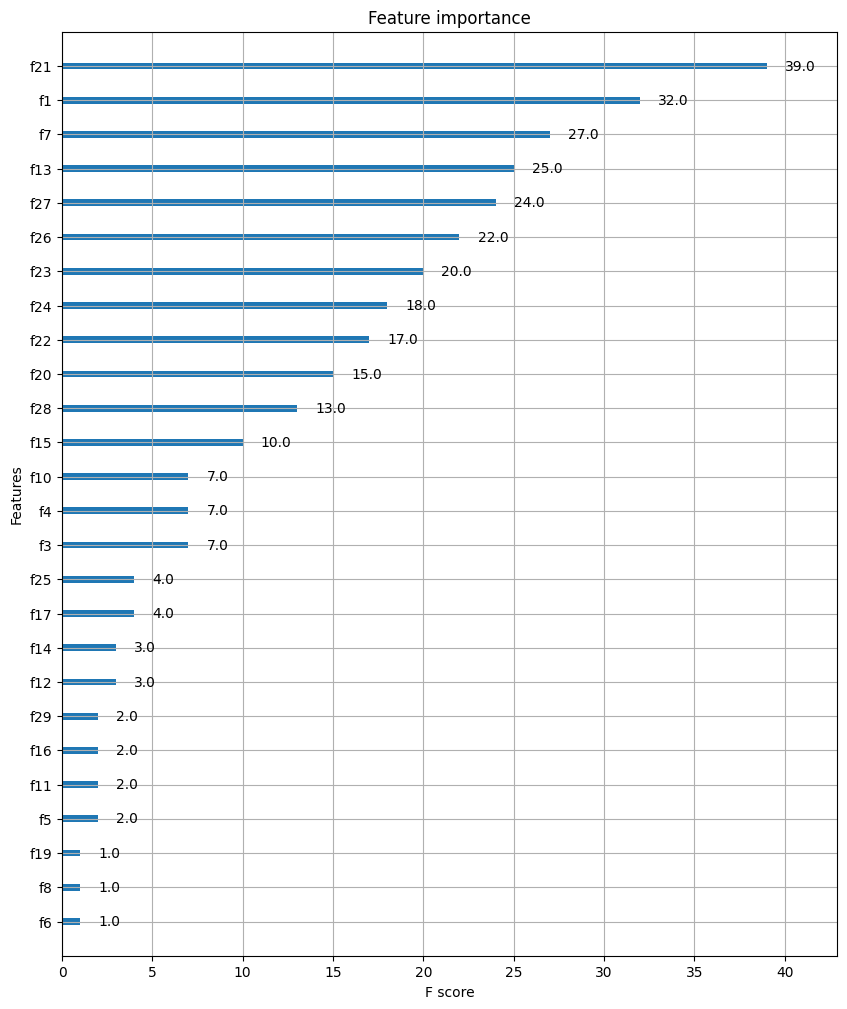

In [35]:
from xgboost import plot_importance
import matplotlib.pyplot as plt
%matplotlib inline

fig, ax = plt.subplots(figsize=(10,12))
# 사이킷런 Wrapper class 입력해도 무방
plot_importance(xgb_wrapper, ax=ax)

### 4.7. LightGBM

#### LightGBM 적용-위스콘신 유방암 예측

In [36]:
# 파이썬 패키지 lightgbm에서 LGBMClassifier import
from lightgbm import LGBMClassifier

import pandas as pd
import numpy as np
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split

dataset=load_breast_cancer()
ftr=dataset.data
target=dataset.target

# 80% 학습용, 20% 테스트용 데이터 추출
X_train, X_test, y_train, y_test = train_test_split(ftr, target, test_size=0.2, random_state=156)

# 학습용 데이터에서 90% 학습용, 10% 테스트용 데이터로 분리
X_tr, X_eval, y_tr, y_eval = train_test_split(X_train, y_train , test_size=0.1, random_state=156)

lgbm_wrapper=LGBMClassifier(n_estimators=400, learning_rate=0.05, early_stopping_rounds=10, verbose=2)

evals=[(X_tr, y_tr),(X_eval, y_eval)]
lgbm_wrapper.fit(X_tr, y_tr, eval_set=evals, eval_metric="logloss")
preds=lgbm_wrapper.predict(X_test)
pred_proba=lgbm_wrapper.predict_proba(X_test)[:,1]

[LightGBM] [Warning] early_stopping_round is set=10, early_stopping_rounds=10 will be ignored. Current value: early_stopping_round=10
[LightGBM] [Info] Number of positive: 251, number of negative: 158
[LightGBM] [Debug] Dataset::GetMultiBinFromAllFeatures: sparse rate 0.003912
[LightGBM] [Debug] init for col-wise cost 0.000400 seconds, init for row-wise cost 0.001490 seconds
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001998 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4092
[LightGBM] [Info] Number of data points in the train set: 409, number of used features: 30
[LightGBM] [Warning] early_stopping_round is set=10, early_stopping_rounds=10 will be ignored. Current value: early_stopping_round=10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.613692 -> initscore=0.462858
[LightGBM] [Info] Start training from score 0.462858
[LightGBM] [Warning] No further splits with positive gain, best gain:

In [37]:
get_clf_eval(y_test, preds, pred_proba)

오차 행렬
[[34  3]
 [ 2 75]]
정확도:  0.9561, 정밀도:  0.9615, 재현율: 0.9740


* 시각화

<Axes: title={'center': 'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

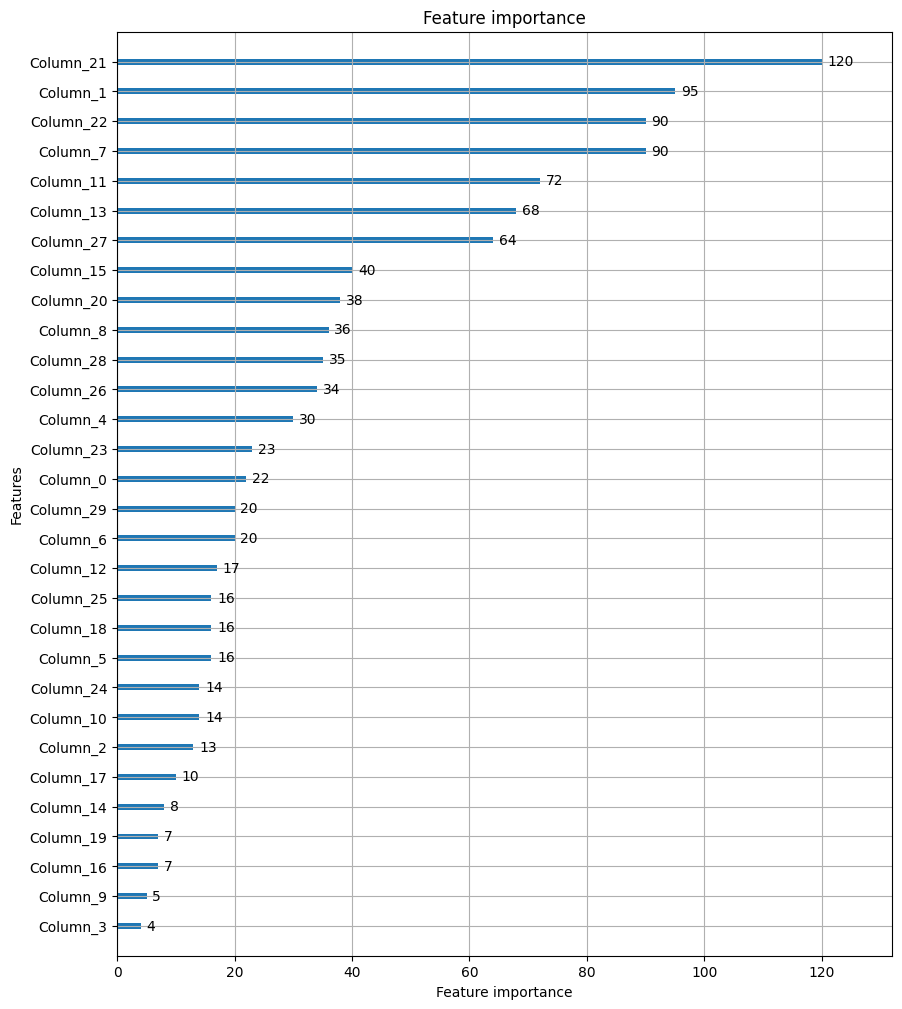

In [38]:
from lightgbm import plot_importance
import matplotlib.pyplot as plt
%matplotlib inline

fig, ax = plt.subplots(figsize=(10,12))
# 사이킷런 Wrapper class 입력해도 무방
plot_importance(lgbm_wrapper, ax=ax)

### 4.10. 스태킹 앙상블

#### 기본 스태킹 모델

In [39]:
import pandas as pd
import numpy as np

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier

from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

cancer_data=load_breast_cancer()
X_data=cancer_data.data
y_label=cancer_data.target

# 80% 학습용, 20% 테스트용 데이터 추출
X_train, X_test, y_train, y_test = train_test_split(X_data, y_label, test_size=0.2, random_state=0)

* 모델 생성

In [40]:
# 개별 ML 모델
knn_clf=KNeighborsClassifier(n_neighbors=4)
rf_clf=RandomForestClassifier(n_estimators=100, random_state=0)
dt_clf=DecisionTreeClassifier()
ada_clf=AdaBoostClassifier(n_estimators=100)

# 스태킹으로 만들어진 데이터 세트를 학습, 예측할 최종 모델
lr_final=LogisticRegression(C=10)

* 학습

In [41]:
knn_clf.fit(X_train, y_train)
rf_clf.fit(X_train, y_train)
dt_clf.fit(X_train, y_train)
ada_clf.fit(X_train, y_train)

AdaBoostClassifier(n_estimators=100)

* 예측 데이터 세트 반환 및 정확도 확인

In [42]:
knn_pred=knn_clf.predict(X_test)
rf_pred=rf_clf.predict(X_test)
dt_pred=dt_clf.predict(X_test)
ada_pred=ada_clf.predict(X_test)

print('KNN 정확도: {0:.4f}'.format(accuracy_score(y_test, knn_pred)))
print('랜덤 포레스트 정확도: {0:.4f}'.format(accuracy_score(y_test, rf_pred)))
print('결정 트리 정확도: {0:.4f}'.format(accuracy_score(y_test, dt_pred)))
print('에이다부스트 정확도: {0:.4f}'.format(accuracy_score(y_test, ada_pred)))


KNN 정확도: 0.9211
랜덤 포레스트 정확도: 0.9649
결정 트리 정확도: 0.9035
에이다부스트 정확도: 0.9561


In [43]:
pred=np.array([knn_pred, rf_pred, dt_pred, ada_pred])
print(pred.shape)

# transpose로 행,열 위치 교환. 각 알고리즘의 예측 결과를 피처로 만들었음
pred=np.transpose(pred)
print(pred.shape)

(4, 114)
(114, 4)


* 예측 데이터를 로지스틱 회귀로 학습, 예측 정확도 측정

In [44]:
lr_final.fit(pred, y_test)
final=lr_final.predict(pred)

print('최종 메타 모델의 예측 정확도: {0:.4f}'.format(accuracy_score(y_test, final)))

최종 메타 모델의 예측 정확도: 0.9737


#### CV 세트 기반의 스태킹

In [45]:
from sklearn.model_selection import KFold
from sklearn.metrics import mean_absolute_error

# 개별 기반 모델에서 최종 메타 모델이 사용할 학습/테스트용 데이터 생성 함수
def get_stacking_base_datasets(model, X_train_n, y_train_n, X_test_n, n_folds):
  # KFold 생성
  kf=KFold(n_splits=n_folds, shuffle=False)
  # 메타 모델이 사용할 학습 데이터 반환을 위한 넘파이 배열 초기화
  train_fold_pred=np.zeros((X_train_n.shape[0],1))
  test_pred=np.zeros((X_test_n.shape[0], n_folds))
  print(model.__class__.__name__, 'model 시작')

  for folder_counter, (train_index, valid_index) in enumerate(kf.split(X_train_n)):
    # 학습 데이터에서 학습/예측할 폴드 데이터 세트 추출
    print('\t 폴드 세트:', folder_counter, '시작')
    X_tr=X_train_n[train_index]
    y_tr=y_train_n[train_index]
    X_te=X_train_n[valid_index]

    # 폴드 세트 내부에서 만들어진 학습 데이터로 기반 모델 학습
    model.fit(X_tr, y_tr)
    # 폴드 세트 내부에서 만들어진 검증 데이터로 기반 모델 예측 후 저장
    train_fold_pred[valid_index,:]=model.predict(X_te).reshape(-1,1)
    # 원본 테스트 데이터를 폴드 세트 내 모델에서 예측 후 저장
    test_pred[:, folder_counter]=model.predict(X_test_n)

  # 폴드 세트 내에서 원본 테스트 데이터 예측한 데이터를 평균 -> 테스트 데이터로 생성
  test_pred_mean=np.mean(test_pred, axis=1).reshape(-1,1)

  # train_fold_pred: 최종 메타 모델 학습 데이터, test_pred_mean: 최종 메타 모델 테스트 데이터
  return train_fold_pred, test_pred_mean


* 학습용/테스트용 데이터 세트 반환

In [46]:
knn_train, knn_test = get_stacking_base_datasets(knn_clf, X_train, y_train, X_test, 7)
rf_train, rf_test = get_stacking_base_datasets(rf_clf, X_train, y_train, X_test, 7)
dt_train, dt_test = get_stacking_base_datasets(dt_clf, X_train, y_train, X_test, 7)
ada_train, ada_test = get_stacking_base_datasets(ada_clf, X_train, y_train, X_test, 7)


KNeighborsClassifier model 시작
	 폴드 세트: 0 시작
	 폴드 세트: 1 시작
	 폴드 세트: 2 시작
	 폴드 세트: 3 시작
	 폴드 세트: 4 시작
	 폴드 세트: 5 시작
	 폴드 세트: 6 시작
RandomForestClassifier model 시작
	 폴드 세트: 0 시작
	 폴드 세트: 1 시작
	 폴드 세트: 2 시작
	 폴드 세트: 3 시작
	 폴드 세트: 4 시작
	 폴드 세트: 5 시작
	 폴드 세트: 6 시작
DecisionTreeClassifier model 시작
	 폴드 세트: 0 시작
	 폴드 세트: 1 시작
	 폴드 세트: 2 시작
	 폴드 세트: 3 시작
	 폴드 세트: 4 시작
	 폴드 세트: 5 시작
	 폴드 세트: 6 시작
AdaBoostClassifier model 시작
	 폴드 세트: 0 시작
	 폴드 세트: 1 시작
	 폴드 세트: 2 시작
	 폴드 세트: 3 시작
	 폴드 세트: 4 시작
	 폴드 세트: 5 시작
	 폴드 세트: 6 시작


* 모델별 학습/테스트 데이터 세트 합치기

In [47]:
Stack_final_X_train=np.concatenate((knn_train, rf_train, dt_train, ada_train), axis=1)
Stack_final_X_test=np.concatenate((knn_test, rf_test, dt_test, ada_test), axis=1)
print('원본 학습 피처 데이터 shape:', X_train.shape, '원본 테스트 피처 shape:', X_test.shape)
print('스태킹 학습 피처 데이터 shape:', Stack_final_X_train.shape,
    '스태킹 테스트 피처 shape:', Stack_final_X_test.shape)


원본 학습 피처 데이터 shape: (455, 30) 원본 테스트 피처 shape: (114, 30)
스태킹 학습 피처 데이터 shape: (455, 4) 스태킹 테스트 피처 shape: (114, 4)


* 최종 메타 모델

In [48]:
lr_final.fit(Stack_final_X_train, y_train)
stack_final=lr_final.predict(Stack_final_X_test)

print('최종 메타 모델의 예측 정확도: {0:.4f}'.format(accuracy_score(y_test, stack_final)))

최종 메타 모델의 예측 정확도: 0.9737


### [파머완 개정 2판] 4.8. 베이지안 최적화 기반 HyperOpt

In [49]:
params={
    'max_depth':[10,20,30,40,50], 'num_leaves':[35,45,55,65],
    'colsample_bytree':[0.5,0.6,0.7,0.8,0.9], 'subsample':[0.5, 0.6, 0.7, 0.8, 0.9],
    'min_child_weight':[10,20,30,40], 'reg_alpha':[0.01, 0.05, 0.1]
}

#### HyperOpt 사용하기

In [50]:
from hyperopt import hp

# -10~10 1간격의 입력 변수 x, -15~15 1간격의 입력 변수 y
search_space={'x': hp.quniform('x',-10,10,1), 'y':hp.quniform('y',-15,15,1)}

In [51]:
from hyperopt import STATUS_OK

# 목적 함수 생성. 변숫값과 변수 검색 공간을 갖는 딕셔너리를 인자로, 특정 값 반환
def objective_func(search_space):
  x=search_space['x']
  y=search_space['y']
  retval=x**20*y

  return retval

In [52]:
from hyperopt import fmin, tpe, Trials
# 입력 결괏값을 저장한 Trials 객체 생성
trial_val=Trials()

# 목적 함수의 최솟값 반환하는 최적 입력 변숫값을 5번의 입력값 시도로 찾아냄 (max_evals=5)
best_01=fmin(fn=objective_func, space=search_space, algo=tpe.suggest, max_evals=5, trials=trial_val, rstate=np.random.default_rng(seed=0))
print('best:', best_01)

100%|██████████| 5/5 [00:00<00:00, 559.02trial/s, best loss: -2199023255552.0]
best: {'x': 4.0, 'y': -2.0}


In [53]:
trial_val=Trials()

# max_evals=20
best_02=fmin(fn=objective_func, space=search_space, algo=tpe.suggest, max_evals=20, trials=trial_val, rstate=np.random.default_rng(seed=0))
print('best:', best_02)

100%|██████████| 20/20 [00:00<00:00, 456.94trial/s, best loss: -1.2157665459056928e+20]
best: {'x': -9.0, 'y': -10.0}


In [54]:
print(trial_val.results)

[{'loss': 1.828079220031488e+16, 'status': 'ok'}, {'loss': 10995116277760.0, 'status': 'ok'}, {'loss': -2199023255552.0, 'status': 'ok'}, {'loss': 13194139533312.0, 'status': 'ok'}, {'loss': 1.2157665459056929e+19, 'status': 'ok'}, {'loss': 15728640.0, 'status': 'ok'}, {'loss': 7e+20, 'status': 'ok'}, {'loss': -1.2157665459056928e+20, 'status': 'ok'}, {'loss': 0.0, 'status': 'ok'}, {'loss': -0.0, 'status': 'ok'}, {'loss': -0.0, 'status': 'ok'}, {'loss': 2.0, 'status': 'ok'}, {'loss': 4.8630661836227715e+19, 'status': 'ok'}, {'loss': 3.656158440062976e+16, 'status': 'ok'}, {'loss': 3.647299637717079e+19, 'status': 'ok'}, {'loss': 3145728.0, 'status': 'ok'}, {'loss': -14680064.0, 'status': 'ok'}, {'loss': -8796093022208.0, 'status': 'ok'}, {'loss': 8.77714929273732e+17, 'status': 'ok'}, {'loss': -0.0, 'status': 'ok'}]


In [55]:
print(trial_val.vals)

{'x': [-6.0, -4.0, 4.0, -4.0, 9.0, 2.0, 10.0, -9.0, -8.0, -0.0, -0.0, 1.0, 9.0, 6.0, 9.0, 2.0, -2.0, -4.0, 7.0, -0.0], 'y': [5.0, 10.0, -2.0, 12.0, 1.0, 15.0, 7.0, -10.0, 0.0, -5.0, -3.0, 2.0, 4.0, 10.0, 3.0, 3.0, -14.0, -8.0, 11.0, -0.0]}


In [56]:
import pandas as pd

losses=[loss_dict['loss'] for loss_dict in trial_val.results]

result_df=pd.DataFrame({'x': trial_val.vals['x'], 'y': trial_val.vals['y'], 'losses': losses})
result_df

,x,y,losses
0,-6.0,5.0,1.828079e+16
1,-4.0,10.0,1.099512e+13
2,4.0,-2.0,-2.199023e+12
3,-4.0,12.0,1.319414e+13
4,9.0,1.0,1.215767e+19
5,2.0,15.0,1.572864e+07
6,10.0,7.0,7.000000e+20
7,-9.0,-10.0,-1.215767e+20
8,-8.0,0.0,0.000000e+00
9,-0.0,-5.0,-0.000000e+00


#### HyperOpt 이용한 XGBoost 하이퍼 파리미터 최적화

In [57]:
import pandas as pd
import numpy as np
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split

dataset=load_breast_cancer()
X_features=dataset.data
y_label=dataset.target

# 80% 학습용, 20% 테스트용 데이터 추출
X_train, X_test, y_train, y_test = train_test_split(X_features, y_label, test_size=0.2, random_state=156)

# 학습용 데이터에서 90% 학습용, 10% 테스트용 데이터로 분리
X_tr, X_val, y_tr, y_val = train_test_split(X_train, y_train , test_size=0.1, random_state=156)

In [58]:
from hyperopt import hp

xgb_search_space={
    'max_depth':hp.quniform('max_depth', 5,20,1),
    'min_child_weight':hp.quniform('min_child_weight', 1,2,1),
    'learning_rate':hp.uniform('learning_rate', 0.01, 0.2),
    'colsample_bytree':hp.uniform('colsample_bytree', 0.5,1)
}

1. 목적 함수 objective_func() 생성

In [59]:
from sklearn.model_selection import cross_val_score
from xgboost import XGBClassifier
from hyperopt import STATUS_OK

# XGBClassifier 정수형 하이퍼 파라미터는 정수형 변환해야 함
# -1*정확도 -> 큰 정확도 값일 수록 최소가 되도록 변환
def objective_func(search_space):
  # n_estimators=100으로 축소
  xgb_clf=XGBClassifier(n_estimators=100, max_depth=int(search_space['max_depth']),
                    min_child_weight=int(search_space['min_child_weight']),
                    learning_rate=search_space['learning_rate'],
                    colsample_bytree=search_space['colsample_bytree'],
                    eval_metric='logloss')
  accuracy=cross_val_score(xgb_clf, X_train, y_train, scoring='accuracy', cv=3)

  # accuracy는 cv=3 수만큼 roc-auc 결과를 리스트로 가짐. 평균해서 반환하되, -1 곱합
  return {'loss': -1*np.mean(accuracy), 'status':STATUS_OK}


2. fmin() 이용하여 최적 하이퍼 파라미터 도출하기

In [60]:
from hyperopt import fmin, tpe, Trials

trial_val=Trials()
best=fmin(fn=objective_func,
          space=xgb_search_space,
          algo=tpe.suggest,
          max_evals=50,
          trials=trial_val, rstate=np.random.default_rng(seed=9))
print('best:', best)

100%|██████████| 50/50 [00:17<00:00,  2.87trial/s, best loss: -0.9670616939700244]
best: {'colsample_bytree': 0.5026505409854508, 'learning_rate': 0.19828428817109603, 'max_depth': 15.0, 'min_child_weight': 1.0}


In [61]:
# 추출된 최적 하이퍼 파라미터 형변환하여 확인

In [62]:
print('colsample_bytree:{0}, learning_rate:{1}, max_depth:{2}, min_child_weight:{3},'.format(round(best['colsample_bytree'],5), round(best['learning_rate'],5), int(best['max_depth']), int(best['min_child_weight'])))

colsample_bytree:0.50265, learning_rate:0.19828, max_depth:15, min_child_weight:1,


3. 최적 하이퍼 파라미터로 XGBClassifier 재학습 및 성능 평가

In [63]:
xgb_wrapper=XGBClassifier(n_estimators=400,
                      learning_rate=round(best['learning_rate'],5),
                      max_depth=int(best['max_depth']),
                      min_child_weight=int(best['min_child_weight']),
                      colsample_bytree=round(best['colsample_bytree'],5),
                      early_stopping_rounds=50, eval_metric='logloss', verbose=True)
evals=[(X_tr, y_tr), (X_val, y_eval)]
xgb_wrapper.fit(X_tr, y_tr, eval_set=evals)
preds=xgb_wrapper.predict(X_test)
pred_proba=xgb_wrapper.predict_proba(X_test)[:,1]

get_clf_eval(y_test, preds, pred_proba)

[0]	validation_0-logloss:0.51230	validation_1-logloss:0.55948
[1]	validation_0-logloss:0.40697	validation_1-logloss:0.47575
[2]	validation_0-logloss:0.32809	validation_1-logloss:0.41760
[3]	validation_0-logloss:0.27049	validation_1-logloss:0.37988
[4]	validation_0-logloss:0.22671	validation_1-logloss:0.34438
[5]	validation_0-logloss:0.19305	validation_1-logloss:0.31788
[6]	validation_0-logloss:0.16589	validation_1-logloss:0.30717
[7]	validation_0-logloss:0.14300	validation_1-logloss:0.30056
[8]	validation_0-logloss:0.12355	validation_1-logloss:0.29707
[9]	validation_0-logloss:0.10737	validation_1-logloss:0.28298
[10]	validation_0-logloss:0.09355	validation_1-logloss:0.26801
[11]	validation_0-logloss:0.08250	validation_1-logloss:0.26738
[12]	validation_0-logloss:0.07357	validation_1-logloss:0.26220
[13]	validation_0-logloss:0.06572	validation_1-logloss:0.26240
[14]	validation_0-logloss:0.05892	validation_1-logloss:0.25570
[15]	validation_0-logloss:0.05247	validation_1-logloss:0.25186
[1